Using non-stationary 10-armed bandit testbed
---
$q_*(a)$ true reward is $ \sim N(0, 1)$.
Then, each one takes an independent random walk,
    by adding a $X \sim N(0,.01^2)$


2 Agents: ($\epsilon = .1$) $\alpha_n$ =
- 1/n
- 0.1


Plot graphs of action value against time-step (upto t = 10^4)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba

In [20]:
@numba.jitclass([('value', numba.float32),])
class Bandit():
    def __init__(self):
        """
        initialise bandit ~N(0, 1^2)
        """
        #self.value = np.random.normal()
        self.value = 0.2

    def get_reward(self):
        """
        Return a stochastic reward ~N(self.vale, 1^2)
        """
        return np.random.normal(loc=self.value, scale=0.1)

    def walk_value(self):
        """
        Change bandit value by adding X~N(0, .01^2)
        """
        self.value += np.random.normal(loc=0, scale=0.01)



In [3]:
numba.typeof(np.zeros((2, 10)))

array(float64, 2d, C)

In [4]:
specAgent = [
    ('epsilon', numba.float32),
    ('k', numba.int8),
    ('alpha', numba.int8),
    ('Q_estimates', numba.float64[:, :]),
    ('rewardLog', numba.types.ListType(numba.types.float64)),
]

@numba.jitclass(specAgent)
class Agent():
    def __init__(self, epsilon=.1, k=10, alpha=0):
        """
        initialise RL agent
        """

        self.epsilon = epsilon
        self.alpha = alpha # NOT Expected to be a lambda function
        self.Q_estimates = np.zeros((2, k))
        self.rewardLog = numba.typed.List.empty_list(numba.types.float64)

    def update_Q(self, banditNum, reward):
        """
        Increment count of Q
        Update estimate of Q
        """
        self.rewardLog.append(reward)
        self.Q_estimates[1][banditNum] += 1
        # Determine the value of alpha
        if self.alpha == 0:
            alpha = .1
        elif self.alpha == 1:
            alpha = 1/(self.Q_estimates[1][banditNum])
        else:
            raise(ValueError)
        self.Q_estimates[0][banditNum] += alpha * (reward - self.Q_estimates[0][banditNum])
        
    def choose_bandit(self):
        """
        Return which bandit to use in interval (0, k - 1)
        based on epsilon-greedy method
        """
        
        if random.random() > self.epsilon:
            # Exploit
            # Get index of best Q-value
            action = np.argmax(self.Q_estimates[0])
        else:
            # Explore all possibilities with equal chance
            k = np.shape(self.Q_estimates)[1]
            action = random.randint(0, k-1)

        #print(f"Action: {action}")
        return action

In [28]:
# Initialise 10 bandits, 2 agents
# Plot graphs
@numba.jit (nopython=True)
def session(bandits, time=10000):
    epsilon = .1
    k = len(bandits)
    agents = [Agent(epsilon, k, 1), Agent(epsilon, k, 1)]
    for i in range(time):
        for agent in agents:
            banditNum = agent.choose_bandit()
            reward = bandits[banditNum].get_reward()
            agent.update_Q(banditNum, reward)

        # walk the bandits
        for bandit in bandits:
            bandit.walk_value()
    return agents

In [29]:
time = 10000
epochs = 2000
totalRewardOverTime = np.zeros((2, time))
bandits = [Bandit() for i in range(10)]

for i in range(epochs):
    agents = session(bandits, time)
    
    # Get totalreward
    for j in range(2):
        totalRewardOverTime[j] += np.array(agents[j].rewardLog)

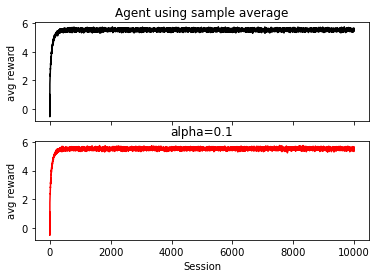

In [30]:
x = np.arange(time)

# Create two subplots sharing y axis
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(x, totalRewardOverTime[0]/time, 'k')
ax1.set(title='Agent using sample average', ylabel='avg reward')
ax1.label_outer()

ax2.plot(x, totalRewardOverTime[1]/time, 'r')
ax2.set_title('alpha=0.1')
ax2.set(xlabel='Session', ylabel='avg reward')

plt.show()

In [ ]:
# Plot percentage correct
best = max([bandit.value for bandit in bandits])

plt.figure(2)
plt.subplot(211)
plt.plot(x, totalRewardOverTime[0]/(time*best))
plt.subplot(212)
plt.plot(x, totalRewardOverTime[1]/(time*best))

plt.show()

In [ ]:
# Plot individual bandit

plt.figure(3)
plt.subplot(211)
plt.plot(x, np.array(agents[0].rewardLog))
plt.subplot(212)
plt.plot(x, np.array(agents[1].rewardLog))

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
print(best)

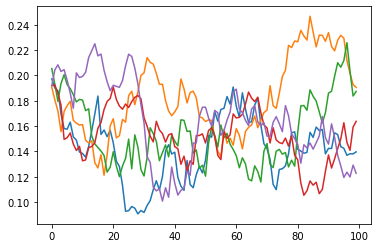

In [26]:
# Plot movemenet of bandits
N = 100
banditN = 5
bandits = [Bandit() for i in range(banditN)]
banditVals = np.zeros((banditN, N))

# Simulate bandit walks
for i in range(N):
    for j in range(banditN):
        bandits[j].walk_value()
        banditVals[j, i] = bandits[j].value

# Plot graph of bandit vals over N
x = np.arange(N)
for i in range(banditN):
    plt.plot(x, banditVals[i])

plt.show()
